# LGBM을 활용한 베이스라인

In [19]:
import pandas as pd
import os
import random
import numpy as np

## 1. 데이터 로딩

In [20]:
data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!

dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
} 

csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path, dtype=dtype, parse_dates=['Timestamp']) 

df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [21]:
df.Timestamp.values

array(['2020-03-24T00:17:11.000000000', '2020-03-24T00:17:14.000000000',
       '2020-03-24T00:17:22.000000000', ...,
       '2020-08-21T01:06:50.000000000', '2020-08-21T01:07:36.000000000',
       '2020-08-21T01:08:49.000000000'], dtype='datetime64[ns]')

In [22]:
def get_month(timestamp):
    timestamp = str(timestamp)
    year_month = timestamp[:7]
    # After EDA, we found data of year 2019 are only composed of December 31th
    # thus setting it to January
    if year_month[:4] == '2019':
        return '01'
    return year_month[5:]

In [23]:
def get_hour(timestamp):
    timestamp = str(timestamp)
    return timestamp[-8:-6]

In [24]:
df['month'] = df.Timestamp.apply(get_month)
df['hour'] = df.Timestamp.apply(get_hour)

In [25]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

In [26]:
diff.describe()

count    2.266586e+06
mean     5.268592e+04
std      4.046780e+05
min      0.000000e+00
25%      1.300000e+01
50%      3.700000e+01
75%      1.350000e+02
max      2.560230e+07
Name: Timestamp, dtype: float64

In [27]:
df.loc[:, ['userID', 'answerCode']].groupby('userID').mean()

,answerCode
userID,
0,0.630872
1,0.853162
2,0.612319
5,0.795918
6,0.442997
...,...
7436,0.466667
7437,0.375000
7438,0.750000


In [28]:
ans = df.loc[:, ['userID', 'answerCode']].groupby('userID').rolling(window=3, closed='left').mean()
df['past_OX'] = ans.values
df['past_OX'] = df.past_OX.fillna(method='bfill')

In [29]:
df['assessment_1'] = df.assessmentItemID.apply(lambda  x: int(x[2]))
df['assessment_2'] = df.assessmentItemID.apply(lambda  x: int(x[4:7]))
df['assessment_3'] = df.assessmentItemID.apply(lambda  x: int(x[7:]))

In [30]:
knowledge_clustered = df.loc[:, ['userID', 'KnowledgeTag']].groupby('userID').rolling(window=3, closed='right').std()
df['knowledge_clustered'] = knowledge_clustered.values
df['knowledge_clustered'] = df.knowledge_clustered.fillna(method='bfill')

In [31]:
df['knowledge_clustered'][df.knowledge_clustered > 100] = 100

/tmp/ipykernel_25528/2551097806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['knowledge_clustered'][df.knowledge_clustered > 100] = 100


In [32]:
df_past = pd.read_csv('train_past_tID.csv')
df_past.head(30)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum,past_testid_1,past_testid_2,past_testid_3,past_testid_4,past_testid_5
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637,-1,-1,-1,-1,-1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.000000,0.947683,1268,0.913187,3040,-1,-1,-1,-1,-1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.000000,0.947683,1268,0.913187,3040,-1,-1,-1,-1,-1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.000000,0.947683,1268,0.913187,3040,-1,-1,-1,-1,-1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.947683,1268,0.913187,3040,-1,-1,-1,-1,-1
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,5.0,5,1.000000,0.947683,1268,0.913187,3040,-1,-1,-1,-1,-1
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,6.0,6,1.000000,0.790562,1223,0.799552,3570,A060000001,-1,-1,-1,-1
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,6.0,7,0.857143,0.790562,1223,0.799552,3570,A060000001,-1,-1,-1,-1
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,7.0,8,0.875000,0.790562,1223,0.799552,3570,A060000001,-1,-1,-1,-1
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,8.0,9,0.888889,0.790562,1223,0.799552,3570,A060000001,-1,-1,-1,-1


In [33]:
df[['past_testid_1', 'past_testid_2', 'past_testid_3', 'past_testid_4', 'past_testid_5']] = df_past[['past_testid_1', 'past_testid_2', 'past_testid_3', 'past_testid_4', 'past_testid_5']]

In [34]:
df.tail(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,month,hour,past_OX,assessment_1,assessment_2,assessment_3,knowledge_clustered,past_testid_1,past_testid_2,past_testid_3,past_testid_4,past_testid_5
2266576,7440,A030197005,A030000197,0,2020-10-21 08:33:20,1984,10,08,0.000000,3,197,5,0.0,A030000136,A050000096,-1,-1,-1
2266577,7441,A030071001,A030000071,0,2020-06-05 06:46:41,438,06,06,0.333333,3,71,1,0.0,-1,-1,-1,-1,-1
2266578,7441,A030071002,A030000071,0,2020-06-05 06:48:43,438,06,06,0.333333,3,71,2,0.0,-1,-1,-1,-1,-1
2266579,7441,A030071003,A030000071,1,2020-06-05 06:49:23,438,06,06,0.333333,3,71,3,0.0,-1,-1,-1,-1,-1
2266580,7441,A030071004,A030000071,0,2020-06-05 06:49:57,438,06,06,0.333333,3,71,4,0.0,-1,-1,-1,-1,-1
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,06,06,0.333333,3,71,5,0.0,-1,-1,-1,-1,-1
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,08,01,0.333333,4,165,1,100.0,A030000071,-1,-1,-1,-1
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,08,01,0.333333,4,165,2,100.0,A030000071,-1,-1,-1,-1
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,08,01,0.666667,4,165,3,0.0,A030000071,-1,-1,-1,-1
2266585,7441,A040165004,A040000165,1,2020-08-21 01:08:49,8836,08,01,1.000000,4,165,4,0.0,A030000071,-1,-1,-1,-1


In [35]:
cate = sum([['testId', 'assessmentItemID', 'KnowledgeTag', 'month', 'hour'],
            [f'past_testid_{i}' for i in range(1, 6)],
           ], [])

## 2. Feature Engineering

In [36]:
def feature_engineering(df):    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    return df

In [37]:
df = feature_engineering(df)

In [38]:
for c in cate:
    df[c] = df[c].astype('category')

In [39]:
df.sample(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,month,hour,past_OX,assessment_1,...,past_testid_3,past_testid_4,past_testid_5,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
736156,1063,A050188003,A050000188,1,2020-09-06 00:59:45,10402,09,00,0.666667,5,...,A050000182,A050000180,A050000173,907.0,1185,0.765401,0.862637,471.0,0.823626,2517.0
2018749,4265,A030047001,A030000047,1,2020-06-14 12:02:39,373,06,12,1.000000,3,...,A030000041,A030000029,A030000006,45.0,133,0.338346,0.737778,996.0,0.780590,3362.0
2097700,4776,A070065004,A070000065,0,2020-06-23 06:09:57,9171,06,06,0.333333,7,...,A070000061,A010000018,A070000051,34.0,71,0.478873,0.417411,561.0,0.463111,929.0
1956307,3969,A090034005,A090000034,0,2020-12-24 05:38:32,10610,12,05,0.000000,9,...,A090000037,A090000025,A090000026,83.0,239,0.347280,0.440934,642.0,0.388278,212.0
2149286,5184,A020103002,A020000103,1,2020-09-24 08:53:19,8003,09,08,0.666667,2,...,A020000097,A070000084,A070000082,27.0,50,0.540000,0.610526,812.0,0.731937,3181.0
1094311,1665,A010118003,A010000118,1,2020-08-19 02:17:26,6774,08,02,0.333333,1,...,A020000186,A020000179,A020000177,139.0,235,0.591489,0.729154,1163.0,0.805804,4054.0
1314425,2117,A040111003,A040000111,1,2020-09-01 04:03:06,2097,09,04,0.666667,4,...,A070000104,A040000106,A070000102,145.0,204,0.710784,0.695238,949.0,0.628477,1514.0
512640,721,A010183002,A010000183,1,2020-06-02 06:59:50,7812,06,06,1.000000,1,...,A010000035,A010000189,A010000088,412.0,560,0.735714,0.804348,148.0,0.827942,1766.0
1840921,3508,A030148002,A030000148,1,2020-10-13 06:09:27,7818,10,06,0.666667,3,...,A030000127,A030000144,A030000142,141.0,208,0.677885,0.625993,867.0,0.504294,2055.0
1886163,3674,A010173001,A010000173,1,2020-08-21 02:31:50,7811,08,02,0.333333,1,...,A010000162,A010000161,A010000156,74.0,89,0.831461,0.767407,518.0,0.805773,1954.0


## 3. Train/Test 데이터 셋 분리

In [40]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [41]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['month', 'hour', 'past_OX', 'assessment_1', 'assessment_2', 'assessment_3', 'knowledge_clustered',
         'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum',
         'assessmentItemID', 'past_testid_1', 'past_testid_2', 'past_testid_3', 'past_testid_4', 'past_testid_5']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [ ]:
# !pip install lightgbm

In [42]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [43]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [44]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19358
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855


/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.467834	valid_1's binary_logloss: 0.547522
[200]	training's binary_logloss: 0.450512	valid_1's binary_logloss: 0.546767
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.452813	valid_1's binary_logloss: 0.546096
VALID AUC : 0.7981027628702048 ACC : 0.7219730941704036



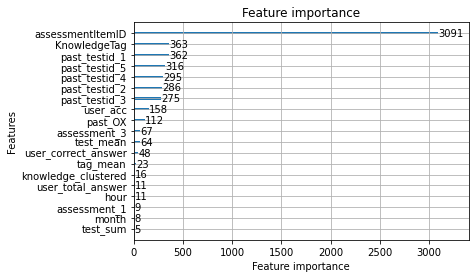

In [45]:
# INSTALL MATPLOTLIB IN ADVANCE
image = lgb.plot_importance(model)

In [ ]:
import wandb

In [ ]:
wandb.init()

In [ ]:
wandb.log({"examples": [wandb.Image(image, caption="Label")]})
# or
# example_images.append(wandb.Image(
#                 data[0], caption="Pred: {} Truth: {}".format(pred[0].item(), target[0])))
# wandb.log({"Examples": example_images})


## 5. Inference

In [52]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])

In [53]:
test_df['month'] = test_df.Timestamp.apply(get_month)
test_df['hour'] = test_df.Timestamp.apply(get_hour)

In [54]:
diff = test_df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

In [55]:
ans = test_df.loc[:, ['userID', 'answerCode']].groupby('userID').rolling(window=3, closed='left').mean()
test_df['past_OX'] = ans.values
test_df['past_OX'] = test_df.past_OX.fillna(method='bfill')

In [56]:
test_df['assessment_1'] = test_df.assessmentItemID.apply(lambda  x: int(x[2]))
test_df['assessment_2'] = test_df.assessmentItemID.apply(lambda  x: int(x[4:7]))
test_df['assessment_3'] = test_df.assessmentItemID.apply(lambda  x: int(x[7:]))

In [57]:
knowledge_clustered = test_df.loc[:, ['userID', 'KnowledgeTag']].groupby('userID').rolling(window=3, closed='right').std()
test_df['knowledge_clustered'] = knowledge_clustered.values
test_df['knowledge_clustered'] = test_df.knowledge_clustered.fillna(method='bfill')
test_df['knowledge_clustered'][test_df.knowledge_clustered > 100] = 100

/tmp/ipykernel_25528/3787898913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['knowledge_clustered'][test_df.knowledge_clustered > 100] = 100


In [58]:
def past_testid_maker(df_in,num = 1):
    #유저 testid group 전처리
    df_in.groupby(['userID'])['testId'].unique()
    userIDs = df_in['userID'].unique()
    gp_uniq_u_tID = df_in.groupby(['userID'])['testId'].unique()
    grouped = df_in.groupby(['userID','testId'])
    
    # 실제 연산
    num = 5 # testId = shift 수
    for i in range(1,num+1):
        list_of_df = [] = [] # concat으로 모으는 df
        for user in (userIDs):
            unq_testid_by_user = gp_uniq_u_tID[user] # 유저별 testid 배열 
            for j in range(len(unq_testid_by_user)):
                if j-i < 0:
                    temp = grouped.get_group((user,unq_testid_by_user[j])).copy()
                    temp[f'past_testid_{i}'] = -1
                else:
                    temp = grouped.get_group((user,unq_testid_by_user[j])).copy()
                    temp[f'past_testid_{i}'] = unq_testid_by_user[j-i]
                list_of_df.append(temp)
        df_cat = pd.concat(list_of_df)
        df_in[f'past_testid_{i}'] = df_cat[f'past_testid_{i}']
    return df_in

In [61]:
test_df_past = pd.read_csv('test_past_tID.csv')

In [62]:
test_df[[f'past_testid_{i}' for i in range(1, 6)]] = test_df_past[[f'past_testid_{i}' for i in range(1, 6)]]

In [63]:
# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [64]:
for c in cate:
    test_df[c] = test_df[c].astype('category')

In [65]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [66]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/submission.csv
